# Building Character Level Language Model

## Introduction

A **language model** assigns a probability to every sequence of words.

$$P(w_1, w_2,\dots, w_n)=P(w_1)P(w_2|w_1)P(w_3|w_1,w_2) \times \dots \times P(w_n|w_1,w_2, \dots, w_{n-1})$$

### Applications

- **Translation**: We can compare different orderings of words:
<h6 align="center">P(he likes apple) > P(apple likes he)</h6>
<br>
- **Speech Recognition**: We can choose words:
<h6 align="center">P(he likes apple) > P(apple licks he)</h6>

## Libraries

In [6]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os
import sys
import random
import pickle

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm_notebook

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

#from utils import *
#from data_utils import Vocabulary
#from train_utils import train

from IPython.core.debugger import Pdb  ## DEBUGGING ##

# setup
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12., 6.)
pdb = Pdb()
use_gpu = torch.cuda.is_available()

Helper functions

In [7]:
def plot_loss(trn_hist, val_hist):
    plt.plot(trn_hist, label='Training Loss')
    plt.plot(val_hist, label='Validation Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

In [8]:
## Helper Functions
import re
import spacy
import torch
from torch.autograd import Variable


NLP = spacy.load('en_core_web_sm')


def to_var(x, volatile=False):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, volatile=volatile)


def detach(x):
    """Wraps hidden states in new tensors, detaching them from their history."""
    if isinstance(x, torch.Tensor):
        return x.detach()
    else:
        return tuple(detach(v) for v in x)

    
    
def tokenizer(text):
    text = re.sub(b'\u200c'.decode("utf-8", "strict"), " ", text)   # replace half-spaces with spaces
    text = re.sub('\n', ' ', text)
    text = re.sub('-', ' - ', text)
    text = re.sub('[ ]+', ' ', text)
    text = re.sub('\.', ' .', text)
    text = re.sub('\،', ' ،', text)
    text = re.sub('\؛', ' ؛', text)
    text = re.sub('\؟', ' ؟', text)
    text = re.sub('\. \. \.', '...', text)
    
    return [w.text for w in NLP.tokenizer(str(text))]

class Vocabulary(object):
    
    def __init__(self):
        self.word2index = {}
        self.index2word = {}
        self.word2count = {}
        self.num_words = 0
        
    def add_word(self, word):
        if not word in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1
        
    def add_words(self, words):
        for word in words:
            self.add_word(word)
    
    def __len__(self):
        return self.num_words
    
    

<>:27: SyntaxWarning: invalid escape sequence '\u'
<>:31: SyntaxWarning: invalid escape sequence '\.'
<>:35: SyntaxWarning: invalid escape sequence '\.'
<>:27: SyntaxWarning: invalid escape sequence '\u'
<>:31: SyntaxWarning: invalid escape sequence '\.'
<>:35: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipykernel_1830388/2014688387.py:27: SyntaxWarning: invalid escape sequence '\u'
  text = re.sub(b'\u200c'.decode("utf-8", "strict"), " ", text)   # replace half-spaces with spaces
/tmp/ipykernel_1830388/2014688387.py:31: SyntaxWarning: invalid escape sequence '\.'
  text = re.sub('\.', ' .', text)
/tmp/ipykernel_1830388/2014688387.py:35: SyntaxWarning: invalid escape sequence '\.'
  text = re.sub('\. \. \.', '...', text)


In [27]:
def train_epoch(epoch, model, trn_ids, 
                criterion, optimizer, scheduler, 
                num_epochs, batch_size, seq_length):
    
    model.train()
    scheduler.step()
    states = model.init_hidden(batch_size)
    num_batches = trn_ids.size(1) // seq_length    
    trn_loss = 0.0
    trn_acc = 0.0
    
    for i in range(0, trn_ids.size(1) - seq_length, seq_length):
        inputs = to_var(trn_ids[:, i: i + seq_length])
        targets = to_var(trn_ids[:, (i + 1): (i + 1) + seq_length].contiguous())
                
        # Forward
        states = detach(states)
        outputs, states = model(inputs, states)
        
        # accuracy
        _, predictions = torch.max(outputs, dim=1)
        acc = torch.mean((predictions == targets.view(-1)).float())
        trn_acc = (trn_acc * i + acc.item()) / (i + 1) 
        
        # loss
        loss = criterion(outputs, targets.view(-1))
        trn_loss = (trn_loss * i + loss.item()) / (i + 1)  
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), 0.3)
        optimizer.step()
        
        # report
        step = (i + 1) // seq_length
        sys.stdout.flush()
        sys.stdout.write('\rTraining: Epoch [%d/%d], Step [%d/%d], Loss: %.3f, Perp: %.2f, Acc: %-15.2f' % 
              (epoch + 1, num_epochs, step + 1, num_batches, trn_loss, np.exp(trn_loss), trn_acc))
    
    return trn_loss


def validate_epoch(epoch, model, val_ids, criterion, 
                   num_epochs, batch_size, seq_length):
    
    model.eval()
    states = model.init_hidden(batch_size)
    num_batches = val_ids.size(1) // seq_length        
    val_loss = 0.0
    val_acc = 0.0
    
    for i in range(0, val_ids.size(1) - seq_length, seq_length):
        inputs = to_var(val_ids[:, i: i + seq_length], volatile=True)
        targets = to_var(val_ids[:, (i + 1): (i + 1) + seq_length].contiguous())
                
        # Forward
        states = detach(states)
        outputs, states = model(inputs, states)
        
        # accuracy
        _, predictions = torch.max(outputs, dim=1)
        acc = torch.mean((predictions == targets.view(-1)).float())
        val_acc = (val_acc * i + acc.item()) / (i + 1) 
        
        # loss
        loss = criterion(outputs, targets.view(-1))
        val_loss = (val_loss * i + loss.item()) / (i + 1)  
                
        # report
        step = (i + 1) // seq_length
        sys.stdout.flush()
        sys.stdout.write('\rValidation: Epoch [%d/%d], Step [%d/%d], Loss: %.3f, Perp: %.2f, Acc: %-15.2f' % 
              (epoch + 1, num_epochs, step + 1, num_batches, val_loss, np.exp(val_loss), val_acc))
        
    return val_loss


def train(model, trn_ids, val_ids, 
          criterion, optimizer, scheduler, 
          num_epochs, batch_size, seq_length):
    
    best_loss = float('Inf')
    best_wgts = None
    
    trn_hist, val_hist = [], []

    for epoch in range(num_epochs):

        trn_loss = train_epoch(epoch, model, trn_ids, 
                               criterion, optimizer, scheduler, 
                               num_epochs, batch_size,  seq_length)
        
        val_loss = validate_epoch(epoch, model, val_ids, criterion, 
                                  num_epochs, batch_size, seq_length)
        
        trn_hist.append(trn_loss)
        val_hist.append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_wgts = model.state_dict().copy()
            model.save(epoch, val_loss)
    
    # load best model weights
    model.load_state_dict(best_wgts)
    return trn_hist, val_hist

## Data

In [16]:
data_dir = '/mnt/home/mnikzad/ML_Practice/Language-Model/data'
train_data = f'{data_dir}/fa.ghomshei.txt'

output_dir = f'{data_dir}/char/models'
if not os.path.exists(output_dir):
    os.makedirs(output_dir, exist_ok=True)

### Statistics

In [12]:
def cal_stats(corpus_path):
    # collect the number of tokens used in each sentence of the corpus in a list
    lengths = [len(s) for s in open(corpus_path, encoding='utf8').read().split('\n')]
    
    # compute stats
    total = sum(lengths)
    mean = np.mean(lengths)
    std = np.std(lengths)
    
    # print stats
    print('Total characters in the corpus = {}\n'.format(total))
    print('Mean = {:.2f}'.format(mean))
    print('Std  = {:.2f}'.format(std))
    print('95% confidence interval = [{:.2f}, {:.2f}]'.format(mean-2*std, mean+2*std))
    
    # plot histogram
    plt.hist(lengths, bins=20)
    plt.show()

Total characters in the corpus = 870258

Mean = 139.24
Std  = 98.89
95% confidence interval = [-58.54, 337.02]


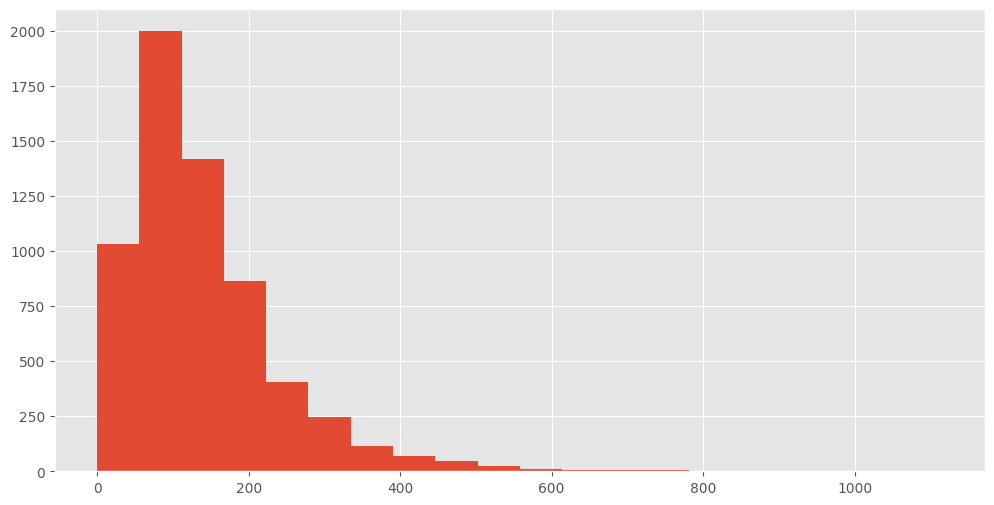

In [17]:
cal_stats(train_data)

### Corpus

In [18]:
class Corpus(object):
    
    def __init__(self, corpus_path):
        self.vocabulary = Vocabulary()
        self.corpus_path = corpus_path
        self.num_sentences = len([line for line in open(corpus_path, encoding='utf8')])
    
    def get_data(self, batch_size=20, split_ratio=0.2):
        
        # First pass: add words to the vocabulary
        trn_tokens, val_tokens = [], []
        with open(self.corpus_path, encoding='utf8') as f:
            for line in tqdm_notebook(f, desc='Building Vocab...', total=self.num_sentences):
                tokens = line
                if len(line) <= 10: continue
                if random.random() < split_ratio:
                    val_tokens += tokens
                else:
                    trn_tokens += tokens
        
        counter = Counter(trn_tokens + val_tokens)        
        vocabs = [(w, c) for (w, c) in counter.items()]
        
        for i, (word, count) in enumerate(sorted(vocabs, key=lambda x: x[1], reverse=True)):
            self.vocabulary.word2index[word] = i
            self.vocabulary.word2count[word] = count
            self.vocabulary.index2word[i] = word
            self.vocabulary.num_words += 1        
        
        # Second pass: Tokenize file content        
        # train ids
        trn_ids = torch.LongTensor(len(trn_tokens))
        for idx, token in enumerate(trn_tokens):
            trn_ids[idx] = self.vocabulary.word2index[token] 
        
        # validation ids
        val_ids = torch.LongTensor(len(val_tokens))
        for idx, token in enumerate(val_tokens):
            val_ids[idx] = self.vocabulary.word2index[token] 
        
        num_batches = trn_ids.size(0) // batch_size
        trn_ids = trn_ids[: num_batches * batch_size]
        
        num_batches = val_ids.size(0) // batch_size
        val_ids = trn_ids[: num_batches * batch_size]

        return trn_ids.view(batch_size, -1), val_ids.view(batch_size, -1)

### Hyper-parameters

In [19]:
# LSTM hyper-parameters
embed_size = 1500
hidden_size = 1500
num_layers = 2

# Training hyper-parameters
num_epochs = 40
batch_size = 50
seq_length = 150
learning_rate = 0.001

### Load Data

In [20]:
corpus = Corpus(train_data)
trn_ids, val_ids = corpus.get_data(batch_size)
vocab_size = len(corpus.vocabulary)

# save vocabs and ids
pickle.dump(corpus.vocabulary, open(f'{output_dir}/vocab.pkl', 'wb'))
np.save(f'{output_dir}/trn_ids.npy', trn_ids.view(-1).numpy())
np.save(f'{output_dir}/val_ids.npy', val_ids.view(-1).numpy())

/tmp/ipykernel_1830388/4087979219.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(f, desc='Building Vocab...', total=self.num_sentences):


Building Vocab...:   0%|          | 0/6249 [00:00<?, ?it/s]

In [21]:
vocab_size = len(corpus.vocabulary)
print(vocab_size)
print(trn_ids.size())
print(val_ids.size())

100
torch.Size([50, 14109])
torch.Size([50, 3419])


In [22]:
most_commons = [(w, c) for (w, c) in corpus.vocabulary.word2count.items()][:20]

for w, c in most_commons:
    print(w, c)

  183459
ا 94377
ن 53363
ر 52954
ی 51199
د 50744
و 43438
ه 42701
م 36849
ب 30154
ت 27292
ک 22516
س 17949
ش 14869
ز 14546
خ 13575
ل 12004
آ 11975
گ 10941
ف 8676


## LSTM For Language Modeling

In [24]:
class LSTM_LM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1, drop=0.35, tie=True):
        super(LSTM_LM, self).__init__()
        
        if tie:
            embed_size = hidden_size
        
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
            
        self.dropout = nn.Dropout(drop)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=0.35)
        self.fc = nn.Linear(hidden_size, vocab_size)
        
        if tie:
            # Use the same weights both for embedding and classification
            self.fc.weight.data = self.embedding.weight.data
            
        self.init_weights()
        
    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        
    def init_hidden(self, batch_size):
        return (to_var(torch.zeros(self.num_layers, batch_size, self.hidden_size)),
                to_var(torch.zeros(self.num_layers, batch_size, self.hidden_size)))
        
    def forward(self, x, hidden):
        # embed word ids to vectors
        x = self.embedding(x)
        x = self.dropout(x)  # DROPOUT
        
        # forward RNN step
        x, hidden = self.lstm(x, hidden)
        x = self.dropout(x)  # DROPOUT
        
        # reshape output to (bs * seq_length, hidden_size)
        x = x.contiguous().view(x.size(0) * x.size(1), x.size(2))
        
        # decode hidden states of all time steps
        x = self.fc(x)
        
        return x, hidden
    
    def save(self, epoch, loss, save_to=output_dir):
        if not os.path.exists(output_dir):
            os.mkdir(output_dir)
        filename = output_dir + '/lm-quran-char-epoch-{}-em-{}-hi-{}-nl-{}-{:.2f}-{:.2f}.pth'.format(
            epoch, self.embed_size, self.hidden_size, self.num_layers, loss, np.exp(loss))
        torch.save(self.state_dict(), filename)

#### Tie Weights (Embedding and classification)

<h6>Idea:</h6> Reuse Embeddings for Classification, which greatly reduces the number of trainable parameters:
- [Tying Word Vectors and Word Classifiers: A Loss Framework for Language Modeling (Inan et al. 2016)](https://arxiv.org/pdf/1611.01462.pdf)

### Define model

In [25]:
# model
model = LSTM_LM(vocab_size, embed_size, hidden_size, num_layers, drop=0.65)
if use_gpu:
    model = model.cuda()

# loss function
criterion = nn.CrossEntropyLoss()
if use_gpu:
    criterion = criterion.cuda()
    
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

### Training

In [33]:
hist = train(model, trn_ids, val_ids, 
             criterion, optimizer, scheduler, 
             10, batch_size, seq_length)

/tmp/ipykernel_1830388/794121866.py:32: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.3)


Training: Epoch [1/10], Step [94/94], Loss: 0.441, Perp: 1.56, Acc: 0.86           

/tmp/ipykernel_1830388/2014688387.py:14: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)


Validation: Epoch [10/10], Step [22/22], Loss: 0.342, Perp: 1.41, Acc: 0.93           

In [31]:
plot_loss(*hist)

NameError: name 'hist' is not defined

In [34]:
torch.save(model.state_dict(), 'masnavi-lm-char-10-1500-2.pth')

### Sampling

<h6>Algorithm:</h6>
1. **Initialize** the LSTM state (`h`, `c`) with zeros.

2. Pick a **random word** from vocabulary as the seed.

3. while number of generated samples is less than the desired:
 
 3.1 **Feed** the LSTM using the word generated from previous time-step.
 
 3.2 Perform **forward computations** to create the probabilty distribution vector for vocabularies.
 
 3.3 Pick a **random word** from vocabulary according to the probabilty distribution from LSTM.

In [37]:
def get_sample(model, sample_len):
    model.eval()
    sample = ''
    state = model.init_hidden(1)

    # select a random word id to start sampling
    probs = torch.ones(vocab_size)
    inp = to_var(torch.multinomial(probs, num_samples=1).unsqueeze(1), volatile=True)

    for i in tqdm_notebook(range(sample_len)):
        output, state = model(inp, state)

        # Sample an id
#         pdb.set_trace()
        probs = output.squeeze().data.exp().cpu()
        char_id = torch.multinomial(probs, 1)[0]

        # Feed sampled word id to next time step
        inp.data.fill_(char_id)

        # write to file
        char_id_sample = char_id.item()
        sample += corpus.vocabulary.index2word[char_id_sample]
    
    return sample

In [38]:
sample = get_sample(model, 2000)
print(sample)

/tmp/ipykernel_1830388/2014688387.py:14: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)
/tmp/ipykernel_1830388/200812823.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(sample_len)):


  0%|          | 0/2000 [00:00<?, ?it/s]

به روی آنها آیند گروهی هم از آشان می‌ترسم.
پس همه فرشتگان غذا جهنم را از (دین) خود برگردانیدیم (و به او ایمان آورد) بر شما گواهی می‌دهیم که تو را به رسالت فرستادیم، صالح به قوم خود گفت: به خدا کافر شو؛ پس از آنکه خدا مقام ایمان را آفریده برای شما بیان کردیم، آنان را از او در گذشت که اوست بسیار آمرزنده و مهربانم.
و نیز عنوانش به کافران گویند: این وعده قیامت کی خواهد بود اگر می‌خواستیم، همه از تو فرستادیم، آیا بعضی دیگر در زمین بداند مالک و گواه مردم سخت ظرم و سعادت مردم است.
و فرعون به سراب آنها (به مکانی) بدین روشنی بیان می‌کند.
و آنان که به آیات خدا و شهود لقای او کافر شدند آنها از رحمت (و نعمت بهشت) من ناامیدند و سخت به عذاب دردناک گرفتار خواهند شد.
و کافران گفتند: چرا این قرآن برای ما بیاوری که ما را از تعبیر آن آگاه کن، که تو را از دیارشان بیرون کرد و هرگز نقض عیسی نیست، پیش از اینها طفل یکبیده (و ناگاه) به سر نگیری و (در نظر دین) ما فرشتگان را فرستادیم، گفت: ای قوم، این خلاف را چنین احسان بسیار داده‌ایم و با آنان هرگی هستیم تا از جنس بزرگ خود (می‌توانید) صید کنید. و چون ایمان آورد

In [ ]:
with open('sample.txt', 'w', encoding='utf8') as f:
    f.write(sample)

## Load a pre-trained Model

In [ ]:
model = LSTM_LM(vocab_size, embed_size=1500, hidden_size=1500, num_layers=2)
model.load_state_dict(torch.load('masnavi-lm-char-10-1500-2.pth'))
if use_gpu:
    model = model.cuda()

In [ ]:
sample = get_sample(model, 2000)
print(sample)

Droput is ineffective for recurrent layers (evantually all hidden units goes to zero)
- Easy solution: use dropout only at the input and output of recurrent layers.
- Also, it is possible and common to use dropout between recurrent layers at different depths.

```python
def forward(self, inp, hidden):
    # embed word ids to vectors
    x = self.embedding(inp)
    x = self.dropout(x)  ### DROPOUT ###
        
    # forward RNN step
    x, hidden = self.lstm(x, hidden)
    x = self.dropout(x)  ### DROPOUT ###
    ...
```

## Other Language Models

- Sub-word level language models
- Character level language models

## Furthere Reading

- [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
- [Oxford Deep NLP 2017 course](https://github.com/oxford-cs-deepnlp-2017/lectures)
- [Natural Language Processing with Deep Learning - Stanford](https://youtu.be/OQQ-W_63UgQ)
- [Deep Learning Book - Chapter 10](http://www.deeplearningbook.org/contents/rnn.html)